# Description du jeu de données

Pour notre projet nous avons décidé de choisir la question suivante : <br> <br>
<center><font color='red'>Peut-on prédire la durée d'un match de tennis à partir des données historiques des matchs ATP ?</font></center>
<br>
Nous avons voulu rompre avec le problème classique de prédire le vainqueur d'un match de tennis et pour nous intéresser à la problématique de la durée des matchs de tennis. Nous avons pensé qu'il pourrait être intéressant pour les sociétés organisatrices de tournois de pouvoir prédire la durée des matchs afin de mieux les agencer et éviter ainsi les reports de match. 

Le jeu de données que nous avons utilisé la base de données disponible sur git hub à l'adresse suivante : https://github.com/JeffSackmann/tennis_atp

Le jeu de données contient les informations de tous les matchs ATP depuis 1968 à aujourd'hui. Pour des questions de fiabilité nous utiliseront les historiques des matchs entre 2000 et 2019. 

Chaque ligne du jeu de données représente une confrontation entre deux joueurs. Nous avons des informations sur le tournoi dans lequel se jour le match (surface, round(8ème, quart-de-finale,...), la surface du terrain, la durée du match ainsi que des information sur les joueurs. Nous expliciterons chaque variable et leurs modalités au fur et à mesure que nous les analyseront.  

In [218]:
import string
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import os 
os.path.abspath('')

'/home/steve/Documents/ENSAE/Projet_ML_Tennis/projet_ML'

In [219]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [220]:
pd.set_option('display.max_columns', 500)
sns.set_style("ticks")

## Importation et nettoyage des données

In [221]:
PATH = '/home/steve/Documents/ENSAE/Projet_ML_Tennis/Data/tennis_atp/'

In [222]:
data = pd.read_csv(PATH+'atp_matches_2010.csv')
for annee in range(2000, 2020):
    data = pd.concat([data, pd.read_csv(PATH+'atp_matches_'+str(annee)+'.csv')], axis=0, sort=False)

Nous avons concaténé plusieurs fichier csv (1 par an). Il est donc nécessaire de reset l'index de la dataframe afin que chaque ligne est un identifiant unique

In [223]:
data.reset_index(inplace=True, drop=True)

In [224]:
data.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1,NaN,Andy Roddick,R,188.0,USA,27.348392,103429,NaN,NaN,Peter Luczak,R,183.0,AUS,30.346338,7-6(5) 6-2,3,R32,84.0,15.0,0.0,63.0,42.0,36.0,14.0,10.0,3.0,3.0,4.0,2.0,56.0,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,Carsten Ball,L,198.0,AUS,22.543463,104999,NaN,NaN,Mischa Zverev,L,190.0,GER,22.370979,7-5 6-1,3,R32,70.0,10.0,3.0,57.0,30.0,23.0,19.0,10.0,0.0,0.0,2.0,2.0,66.0,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,Richard Gasquet,R,185.0,FRA,23.548255,103813,NaN,NaN,Jarkko Nieminen,L,185.0,FIN,28.451745,6-3 4-6 6-4,3,R32,121.0,5.0,4.0,97.0,51.0,33.0,27.0,15.0,5.0,8.0,4.0,0.0,85.0,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,20100103,4,105051,NaN,Q,Matthew Ebden,R,188.0,AUS,22.108145,103781,6,NaN,Jurgen Melzer,L,183.0,AUT,28.621492,7-5 6-1,3,R32,64.0,12.0,1.0,50.0,35.0,30.0,12.0,10.0,3.0,3.0,2.0,1.0,53.0,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,20100103,5,104607,4,NaN,Tomas Berdych,R,196.0,CZE,24.298426,105194,NaN,Q,Nick Lindahl,R,183.0,AUS,21.429158,6-2 6-4,3,R32,69.0,3.0,1.0,46.0,27.0,24.0,14.0,9.0,1.0,1.0,6.0,1.0,69.0,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0


Les valeurs manquantes sont indiquées en NaN. On peut alors directement utiliser la méthode .info() de pandas afin d'identifier quelles colonnes en contiennent.

In [225]:
data.shape

(64694, 49)

In [226]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64694 entries, 0 to 64693
Data columns (total 49 columns):
tourney_id            64694 non-null object
tourney_name          64694 non-null object
surface               64576 non-null object
draw_size             64694 non-null int64
tourney_level         64694 non-null object
tourney_date          64694 non-null int64
match_num             64694 non-null int64
winner_id             64694 non-null int64
winner_seed           26869 non-null object
winner_entry          7670 non-null object
winner_name           64694 non-null object
winner_hand           64676 non-null object
winner_ht             59256 non-null float64
winner_ioc            64694 non-null object
winner_age            64679 non-null float64
loser_id              64694 non-null int64
loser_seed            14651 non-null object
loser_entry           12722 non-null object
loser_name            64694 non-null object
loser_hand            64648 non-null object
loser_ht       

Les colonnes winner_entry, loser_entry, winner_seed, loser_seed contiennent plus de 78% de valeurs manquantes. Les variables winner_entry et loser_entry indiquent comment le joueur s'est qualifié pour le tournoi (qualificatin, invitation, qualifié d'office) et winner_seed, loser_seed indique le numéro du joueur pour le tournois. Du fait du grand nombre de valeurs manquantes et leur faible intérêt vis avis de notre objectif nous pouvons les enlever.  

In [227]:
data.drop(['winner_entry', 'loser_entry', 'winner_seed', 'loser_seed'], axis=1, inplace=True)

In [228]:
data.shape

(64694, 45)

Les valeurs manquantes les plus importantes sont celles sur la colonnes de la durée du match (minutes) car c'est notre varible à prédire. Il manque 10% des lignes sur cettes colonnes nous allons les supprimer.

Il manque également des données pour les données propres au match : <br>
- w/l_svpt ... nombre de services contestés
- w/l_1stIn ... nombre de premiers services in (service sans faute)
- w/l_1stWon ... nombre de premier services gagnés (servi par le joueur)
- w/l_2ndWon ... nombre de deuxièmes services gagnés (servi par le joueur)
- w/l_SvGms ... nombre de jeux servi par le joueur
- w/l_bpSaved ... nombre de balles de break sauvés
- w/l_bpFaced ... nombre de balles de break rencontrés

In [229]:
data['tourney_date'] = pd.to_datetime(data['tourney_date'], yearfirst=True, format='%Y%m%d')
data['year'] = data['tourney_date'].apply(lambda x: x.year)
data = data[~data['tourney_name'].str.startswith('Davis Cup')].copy()
data.dropna(subset=['minutes'], inplace=True)

In [230]:
def contains_ascii_letter(txt):
    gate = False
    for i in range(len(txt)):
        if txt[i] in string.ascii_letters:
            gate = True
            break
    return gate

In [231]:
get_ascii_letter = np.zeros(data.shape[0], dtype=bool)
get_ascii_letter = data['score'].apply(contains_ascii_letter)

data = data[~get_ascii_letter].copy()

In [232]:
data.shape

(54515, 46)

### Valeurs extrêmes

### Corrections
En étudiant les valeurs extrêmes de notre jeu de données nous avons constaté la présence de quelques erreurs concernant la durée de certains matchs. Nous avons constaté que trois matchs étaient anormalement longs. Sur les trois, deux étaient en effet des erreurs de saisies cependant, le troisième correspond au match de Wimbledon (2010) entre Josh Ishner et Nicolas Mahut qui a duré 11h05 s'étalant sur trois jours. On notera que John Ishner est un habitué des longs matchs avec 3 apparitions dans le top 10 des plus longs matchs de l'histoire du tennis.

In [233]:
data[(data['tourney_id']=='2017-0308')&(data['match_num']==297)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
57395,2017-0308,Munich,Clay,32,A,2017-05-01,297,111202,Hyeon Chung,R,NaN,KOR,20.950034,105373,Martin Klizan,L,190.0,SVK,27.805613,6-4 3-6 6-2,3,QF,987.0,4.0,2.0,81.0,47.0,36.0,15.0,13.0,4.0,6.0,8.0,4.0,95.0,49.0,28.0,27.0,14.0,8.0,12.0,78.0,659.0,53.0,880.0,2017


In [234]:
data[(data['tourney_id']=='2016-M001')&(data['match_num']==294)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
53329,2016-M001,Sydney,Hard,32,A,2016-01-11,294,104180,Gilles Muller,L,193.0,LUX,32.676249,104871,Jeremy Chardy,R,188.0,FRA,28.911704,7-6(5) 6-3,3,QF,1146.0,14.0,5.0,59.0,35.0,32.0,13.0,10.0,0.0,0.0,2.0,5.0,69.0,44.0,34.0,10.0,11.0,1.0,3.0,38.0,1105.0,31.0,1255.0,2016


In [235]:
data.loc[data[(data['tourney_id']=='2017-0308')&(data['match_num']==297)].index[0], 'minutes'] = 98
data.loc[data[(data['tourney_id']=='2016-M001')&(data['match_num']==294)].index[0], 'minutes'] = 90

In [238]:
data.to_csv(os.path.abspath('')+'/Data/Données_nettoyées.csv')

## Etudes marcoscopique de ce qui influe sur la durée d'un match de tennis

Tout d'abord nous pouvons nous demander quels sont les facteurs qui influent le plus sur la durée d'un match de tennis. <br>
Nous allons explorer premièrement l'influence de nos variables expliquatives sur la variables à prédire minutes. Le but est de voir si nous pouvons observer de manière "macroscopique" ce qui fait qu'un match est court ou long. <br>

    1) Le nombre de sets nécessaires pour gagner le match (best of 3 / best of 5) ce qui revient au même que de séparer les matchs en "matchs de grand chelem"/"autres matchs"
    2) La surface sur laquelle ce joue le match (clay / hard / grass / carpet) 
    3) Le type de tournois (Grand Slam / Master / Other / Challenger / Satellite) 
    4) Le niveau du tournois du match (32eme / 16eme / 8eme ...) 
    5) La différence de ranking entre les deux joueurs 
    6) Le ranking moyen des deux joueurs (est ce que les joueurs de meilleur niveau on tendance à jouer plus rapidement ou non ?)

### Etudes des corrélations de pearson entre les variables quantitatives

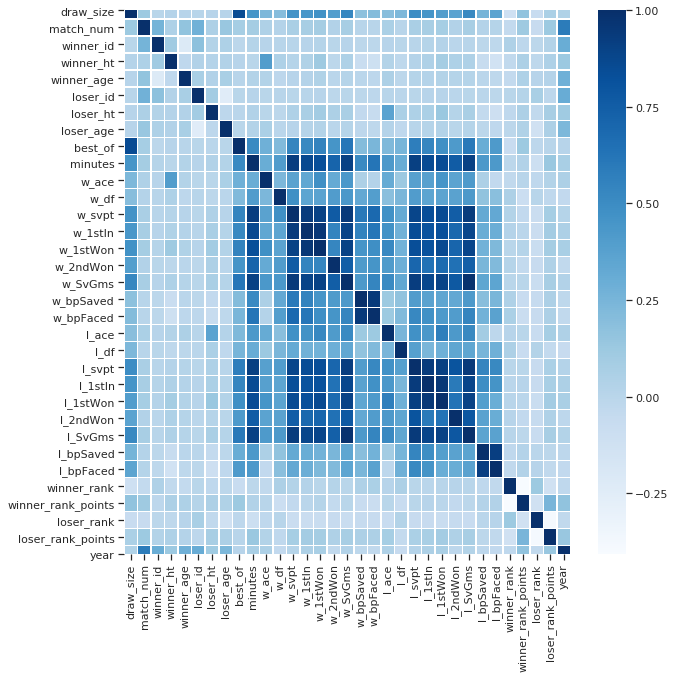

In [193]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(data.corr(), cmap='Blues', linewidths=.5)

Depuis la matrice de corrélation on peut observer que :<br>
- la durée d'un match ("minutes") est fortement corrélée avec les données internes du match. En effet plus un match dure plus le nombre de points joués dans le match est élevé. Cette information n'est pas utile pour notre problématique mais elle explique les fortes corrélations qui apparaissent sur la heatmap.br>
- on remarque également que "minutes" est corrélée avec la variable "best_of". La variable best_of indique si un match se joue en 2 ou 3 sets gagnants (best_of 3, best_of 5). C'est bien la sépration entre matchs de grand chelem et les autres qui apparait.

### Analyse de l'effet de la règle 2 ou 3 sets gagnants sur la durée des matchs

In [194]:
data.groupby(['best_of'])['minutes'].mean()

best_of
3     96.673721
5    148.814782
Name: minutes, dtype: float64

On voit en effet que la durée moyenne des matchs qui se joue en 2 sets gagnants est très largement inférieure à la durée des matchs en 5 sets. 

In [195]:
avg_best_of_3_all = data.groupby(['best_of'])['minutes'].mean()[3]

In [196]:
avg_best_of_5_all = data.groupby(['best_of'])['minutes'].mean()[5]

### La surface du terrain

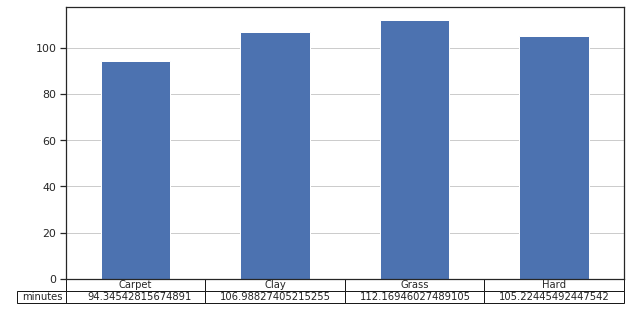

In [197]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['surface'])['minutes'].mean().plot(kind='bar',figsize=(10,5), table=True, grid=True)

Ici on voit que les matchs sur gazon (Grass) on tendance à être plus long que sur les autres surfaces. Cependant ce résultat est contre intuitif. En effet, il est connu que la surface où la balle va la plus vite et offrant le moins de rebond est le gazon. Il est serait donc normal que les matchs les plus rapides aient lieu sur cette surface.<br><br>
Nous allons affiner l'analyse en séparant les matchs best_of_3 des matchs best_of_5.

In [198]:
data.groupby(['best_of', 'surface'])['match_num'].count().unstack()

surface,Carpet,Clay,Grass,Hard
best_of,,,,
3,1364,15306,3521,24271
5,14,2603,2445,4991


On s'aperçoit que le ratio de match best_of_3/best_of_5 est proche de 1 pour le gazon tandis que sur les autres surfaces il y beaucoup plus de matchs en 3 sets gagnants qu'en 5. Ceci explique que la moyenne globale de la durée des matchs sur gazons soit plus élevées que sur les autres matières. <br>
Afin de ne pas biaiser la suite de notre analyse, nous veillerons à toujours séparer ces deux catégories. 

In [199]:
data.groupby(['best_of', 'surface'])['minutes'].mean()

best_of  surface
3        Carpet      93.687683
         Clay        99.372991
         Grass       90.720534
         Hard        96.002925
5        Carpet     158.428571
         Clay       151.767192
         Grass      143.057669
         Hard       150.068323
Name: minutes, dtype: float64

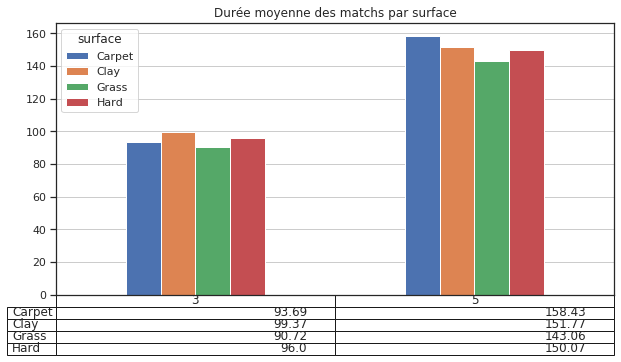

In [200]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'surface'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax
                                                                       , title='Durée moyenne des matchs par surface')

On voit ici qu'en effet la surface al plus rapide est le gazon et la plus lente est la terre battue ou la moquette. 

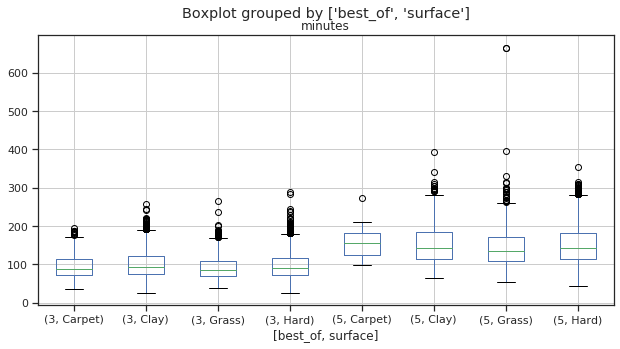

In [201]:
data.boxplot(column=['minutes'], by=['best_of', 'surface'], figsize=(10,5))

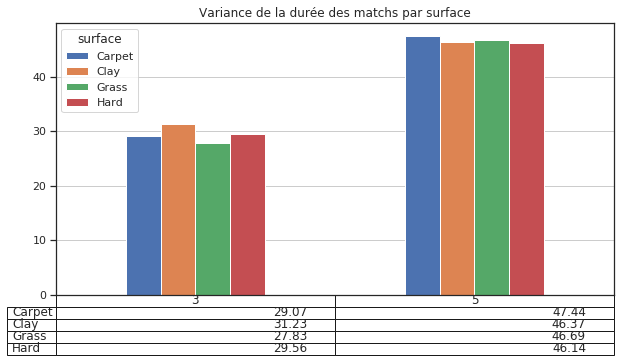

In [202]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'surface'])['minutes'].std().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'surface'])['minutes'].std().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax
                                                                       , title='Variance de la durée des matchs par surface')

L'études des écarts type nous indique que la durée des matchs varie de manière homogène sur toutes les surfaces. <br>
L'objectif est donc de pouvoir expliquer cette variation par d'autres facteurs.

### Le type de tournois 

La variable "tourney_level" informe sur le type de tournoi dans lequel est joué le match. Elle comporte les modalités suivantes :
<br>
- G – Grand Slam (Grand Chelem)
- M – Masters
- A – ATP (500 & 250)
- F – Tour final (ATP finals)

In [203]:
data.groupby(['best_of', 'tourney_level'])['match_num'].count()

best_of  tourney_level
3        A                32959
         F                  289
         M                11214
5        A                   44
         F                    7
         G                 9960
         M                   42
Name: match_num, dtype: int64

In [204]:
data[(data['tourney_level']=='M')&(data['best_of']==5)]

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,year
3698,2000-352,Paris Masters,Carpet,48,M,2000-11-13,47,103498,Marat Safin,R,193.0,RUS,20.796715,102882,Mark Philippoussis,R,196.0,AUS,24.016427,3-6 7-6(7) 6-4 3-6 7-6(8),5,F,209.0,22.0,2.0,157.0,84.0,72.0,39.0,25.0,6.0,8.0,22.0,9.0,161.0,93.0,81.0,38.0,27.0,1.0,2.0,2.0,3530.0,14.0,1535.0,2000
3745,2000-357,Stuttgart Masters,Hard,48,M,2000-10-30,47,101965,Wayne Ferreira,R,185.0,RSA,29.125257,103720,Lleyton Hewitt,R,180.0,AUS,19.679671,7-6(6) 3-6 6-7(5) 7-6(2) 6-2,5,F,251.0,18.0,5.0,194.0,100.0,69.0,52.0,27.0,14.0,20.0,8.0,8.0,170.0,84.0,64.0,40.0,26.0,8.0,14.0,19.0,1234.0,8.0,2367.0,2000
3980,2000-403,Miami Masters,Hard,96,M,2000-03-20,95,101948,Pete Sampras,R,185.0,USA,28.605065,102856,Gustavo Kuerten,R,190.0,BRA,23.523614,6-1 6-7(2) 7-6(5) 7-6(8),5,F,198.0,20.0,9.0,148.0,94.0,75.0,30.0,22.0,5.0,6.0,16.0,4.0,159.0,90.0,61.0,43.0,21.0,11.0,14.0,2.0,2932.0,6.0,2147.0,2000
4043,2000-404,Indian Wells Masters,Hard,64,M,2000-03-13,63,102374,Alex Corretja,R,180.0,ESP,25.921971,102358,Thomas Enqvist,R,190.0,SWE,26.001369,6-4 6-4 6-3,5,F,120.0,10.0,1.0,77.0,38.0,30.0,28.0,14.0,6.0,7.0,8.0,7.0,100.0,54.0,34.0,25.0,15.0,8.0,13.0,26.0,1041.0,10.0,1551.0,2000
4199,2000-410,Monte Carlo Masters,Clay,64,M,2000-04-17,63,101611,Cedric Pioline,R,188.0,FRA,30.839151,103103,Dominik Hrbaty,R,183.0,SVK,22.283368,6-4 7-6(3) 7-6(6),5,F,160.0,12.0,5.0,127.0,61.0,48.0,33.0,17.0,7.0,10.0,7.0,7.0,113.0,57.0,42.0,22.0,17.0,4.0,8.0,12.0,1581.0,24.0,1080.0,2000
4262,2000-414,Hamburg Masters,Clay,64,M,2000-05-15,63,102856,Gustavo Kuerten,R,190.0,BRA,23.676934,103498,Marat Safin,R,193.0,RUS,20.298426,6-4 5-7 6-4 5-7 7-6(3),5,F,232.0,7.0,1.0,165.0,86.0,64.0,41.0,28.0,4.0,11.0,13.0,2.0,177.0,94.0,66.0,38.0,28.0,4.0,11.0,7.0,1887.0,14.0,1387.0,2000
4325,2000-416,Rome Masters,Clay,64,M,2000-05-08,63,102796,Magnus Norman,R,188.0,SWE,23.939767,102856,Gustavo Kuerten,R,190.0,BRA,23.657769,6-3 4-6 6-4 6-4,5,F,185.0,14.0,1.0,121.0,81.0,57.0,21.0,20.0,5.0,9.0,15.0,5.0,142.0,68.0,48.0,34.0,19.0,15.0,21.0,4.0,2314.0,6.0,2012.0,2000
7061,2001-352,Paris Masters,Carpet,48,M,2001-10-29,47,103206,Sebastien Grosjean,R,175.0,FRA,23.419576,102338,Yevgeny Kafelnikov,R,190.0,RUS,27.693361,7-6(3) 6-1 6-7(5) 6-4,5,F,164.0,14.0,2.0,126.0,79.0,59.0,33.0,21.0,1.0,2.0,6.0,6.0,126.0,72.0,59.0,24.0,20.0,7.0,11.0,8.0,2225.0,6.0,2785.0,2001
7108,2001-357,Stuttgart Masters,Hard,48,M,2001-10-15,47,103163,Tommy Haas,R,188.0,GER,23.534565,103018,Max Mirnyi,R,196.0,BLR,24.276523,6-2 6-2 6-2,5,F,93.0,9.0,1.0,62.0,33.0,29.0,20.0,12.0,0.0,0.0,11.0,3.0,78.0,44.0,32.0,9.0,12.0,4.0,10.0,14.0,1600.0,53.0,725.0,2001
7343,2001-403,Miami Masters,Hard,96,M,2001-03-19,95,101736,Andre Agassi,R,180.0,USA,30.888433,102998,Jan Michael Gambill,R,190.0,USA,23.791923,7-6(4) 6-1 6-0,5,F,111.0,8.0,2.0,80.0,61.0,45.0,12.0,13.0,0.0,1.0,9.0,4.0,73.0,30.0,22.0,17.0,12.0,2.0,8.0,3.0,3365.0,19.0,1430.0,2001


La catégorie F est très fortement sous représenté. En effet il sagit uniquement du tournois de fin de saison ATP finals.<br>
On voit également que couper le jeu de données en 2 selon la règle de 2 ou 3 sets gagnants revient pratiquement à répartir les matchs entre grand chelem et les autres tournois.

In [205]:
data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack()

tourney_level,A,F,G,M
best_of,,,,
3,95.779787,104.003460,NaN,99.112181
5,160.522727,148.142857,148.714257,160.500000


In [206]:
data.groupby(['best_of', 'tourney_level'])['minutes'].median().unstack()

tourney_level,A,F,G,M
best_of,,,,
3,90.0,98.0,NaN,93.0
5,148.0,115.0,141.0,140.5


In [207]:
data.groupby(['best_of', 'tourney_level'])['minutes'].describe()

count        mean        std   min     25%    50%  \
best_of tourney_level                                                        
3       A              32959.0   95.779787  29.824865  25.0   72.00   90.0   
        F                289.0  104.003460  32.292661  50.0   78.00   98.0   
        M              11214.0   99.112181  30.653832  28.0   75.00   93.0   
5       A                 44.0  160.522727  48.522107  93.0  123.50  148.0   
        F                  7.0  148.142857  72.792922  96.0   98.00  115.0   
        G               9960.0  148.714257  46.378831  43.0  113.00  141.0   
        M                 42.0  160.500000  54.591275  93.0  120.25  140.5   

                         75%    max  
best_of tourney_level                
3       A              116.0  289.0  
        F              126.0  218.0  
        M              120.0  244.0  
5       A              185.5  300.0  
        F              178.5  273.0  
        G              179.0  665.0  
        M              188.0  314.0

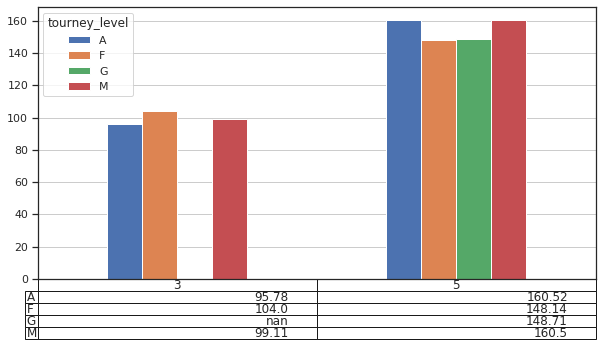

In [208]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack().plot(kind='bar', figsize=(10,5),
                                                                      table=np.round(data.groupby(['best_of', 'tourney_level'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### Le round

La variable "round" indique à quel stade du tournois se situe le match. Elle comporte les modalités suivantes : <br>
- R128 (128ème de finale), R64, R32, R16, R8
- QF (quart de finale), SF (demi finale), F (finale)
- RR (phase de poule), BR (petite finale), ER (Elimination round, tour particulier d'élimination après les qualifications)

In [209]:
data.groupby(['best_of', 'round'])['minutes'].mean().unstack()

round,BR,ER,F,QF,R128,R16,R32,R64,RR,SF
best_of,,,,,,,,,,
3,138.0,85.96875,105.160988,98.843621,98.002555,97.179407,94.873088,95.414547,99.254669,101.779723
5,NaN,NaN,166.891429,159.850318,145.512171,156.536392,150.822115,148.685908,NaN,166.706250


In [210]:
gb_round = data.groupby(['best_of', 'round'])['minutes'].mean()

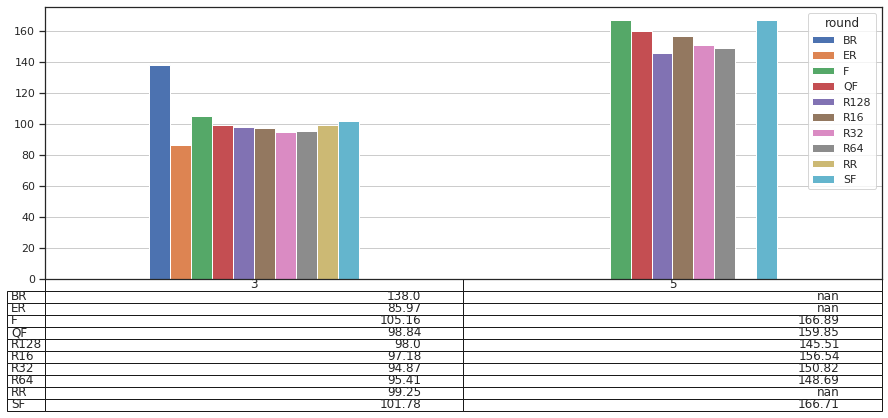

In [211]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'round'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'round'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

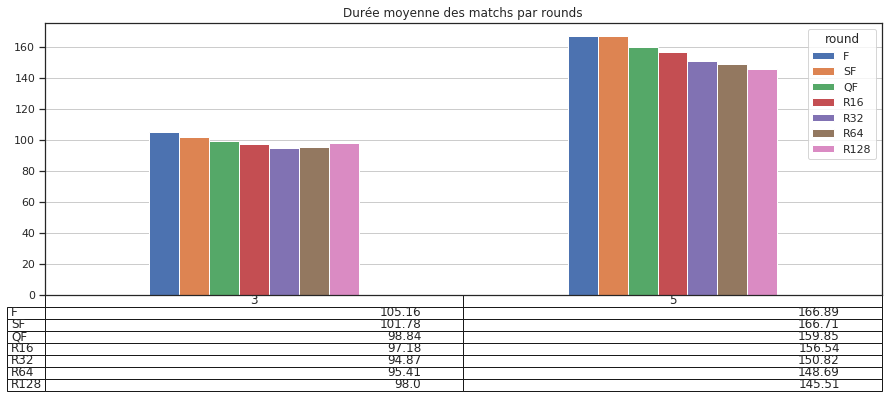

In [212]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'round'])['minutes'].mean().unstack()[['F', 'SF', 'QF', 'R16', 'R32', 'R64', 'R128']].plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'round'])['minutes'].mean().unstack()[['F', 'SF', 'QF', 'R16', 'R32', 'R64', 'R128']].transpose(), 2)
                                                                      , grid=True
                                                                      , ax=ax
                                                                      , title='Durée moyenne des matchs par rounds')

En organisant les rounds 'classiques' par ordre d'importance dans un tournoi on s'aperçoit que les matchs des phases finales sont en moyenne plus longs que les autres.<br>
<font color='red'>On peut alors se demander s'il a lien entre le niveau des matchs et leur durée.</font>

### Analyse de l'évolution de la durée des matchs en fonction du classement des joueurs

Dans cette partie nous allons étudier si il existe un lien entre le niveau d'un match et sa durée. Nous regarderons premièrement si l'homogénéité du classement des adversaires d'un match de tennis à une influence sur sa durée. Deuxièmement nous regarderons si la durée des matchs varie en fonction du classement moyen des deux joueurs. L'idée est de voir si les matchs de plus haut niveau durent plus ou moins longtemps que les autres.

### La différence de classement entre les deux joueurs

In [213]:
data['diff_ranking'] = data.apply(lambda x: abs(x.winner_rank - x.loser_rank), axis=1)

In [214]:
data['diff_ranking'].describe()

count    54358.000000
mean        71.653850
std        111.445747
min          1.000000
25%         19.000000
50%         41.000000
75%         79.000000
max       2125.000000
Name: diff_ranking, dtype: float64

In [215]:
data['diff_ranking_categories'] = pd.cut(data['diff_ranking'], [0,20,50,79,206,466,1000,3000])

In [216]:
data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack()

diff_ranking_categories,"(0, 20]","(20, 50]","(50, 79]","(79, 206]","(206, 466]","(466, 1000]","(1000, 3000]"
best_of,,,,,,,
3,98.819484,97.368107,96.113912,94.900064,92.796382,87.488152,75.686275
5,157.459829,151.364298,145.307614,142.940977,134.895141,136.421687,134.071429


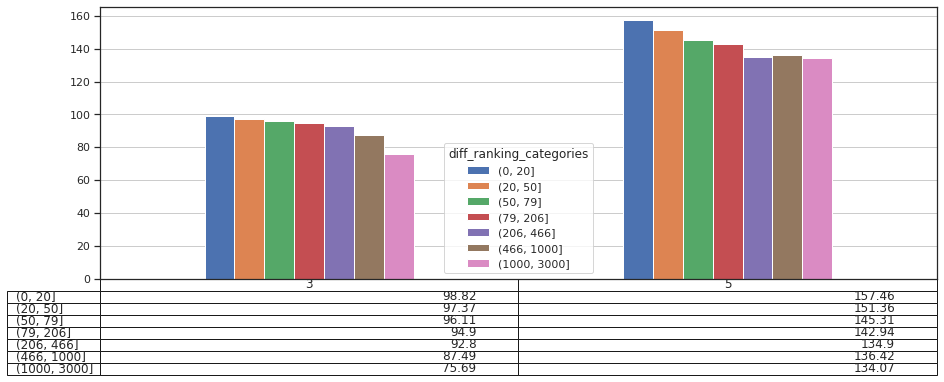

In [217]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'diff_ranking_categories'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

In [44]:
data[['minutes', 'diff_ranking']].corr()

,minutes,diff_ranking
minutes,1.000000,-0.063598
diff_ranking,-0.063598,1.000000


In [160]:
data['diff_ranking_categories'] = pd.cut(data['diff_ranking'], [0,20,50,79,206,466,1000,3000], labels=[1,2,3,4,5,6,7])

In [170]:
data['diff_ranking_categories_2'] = data['diff_ranking_categories'].apply(lambda x: int(x))

In [173]:
data['diff_ranking_categories_2'].values

[3, 3, 2, 5, 5, ..., 1, 1, 1, 1, 1]
Length: 54515
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

In [172]:
data.plot(x='diff_ranking_categories_2', y='minutes', kind='scatter')

ValueError: scatter requires x column to be numeric

In [147]:
data[['diff_ranking_categories']].values

array([[nan],
       [nan],
       [nan],
       ...,
       [nan],
       [nan],
       [nan]])

In [138]:
data[['minutes', 'diff_ranking_categories']].corr()

,minutes
minutes,1.0


### Ranking moyen 

In [45]:
data['avg_ranking'] = data.apply(lambda x: (x.winner_rank + x.loser_rank)/2, axis=1)

In [46]:
data['avg_ranking'].describe()

count    54358.000000
mean        75.231925
std         71.599931
min          1.500000
25%         35.500000
50%         58.000000
75%         90.000000
max       1484.000000
Name: avg_ranking, dtype: float64

In [47]:
data[data['avg_ranking']>90]['avg_ranking'].describe()

count    13555.000000
mean       160.194098
std         97.206507
min         90.500000
25%        104.000000
50%        126.500000
75%        175.000000
max       1484.000000
Name: avg_ranking, dtype: float64

In [48]:
data[data['avg_ranking']>174]['avg_ranking'].describe()

count    3420.000000
mean      282.143129
std       126.791981
min       174.500000
25%       198.500000
50%       238.000000
75%       315.500000
max      1484.000000
Name: avg_ranking, dtype: float64

In [49]:
data[data['avg_ranking']>376]['avg_ranking'].describe()

count     522.000000
mean      525.947318
std       139.960834
min       376.500000
25%       425.000000
50%       490.250000
75%       577.875000
max      1484.000000
Name: avg_ranking, dtype: float64

In [50]:
data['avg_ranking_categories'] = pd.cut(data['avg_ranking'], [0,35,60,90,125,240,500,1500])

In [51]:
data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack()

avg_ranking_categories,"(0, 35]","(35, 60]","(60, 90]","(90, 125]","(125, 240]","(240, 500]","(500, 1500]"
best_of,,,,,,,
3.0,99.892345,97.032786,95.834359,95.346388,94.488605,91.639434,83.668161
5.0,155.778074,146.278750,147.317411,145.449556,147.140330,136.904762,146.916667


In [52]:
data[['minutes', 'avg_ranking']].corr()

,minutes,avg_ranking
minutes,1.000000,-0.079169
avg_ranking,-0.079169,1.000000


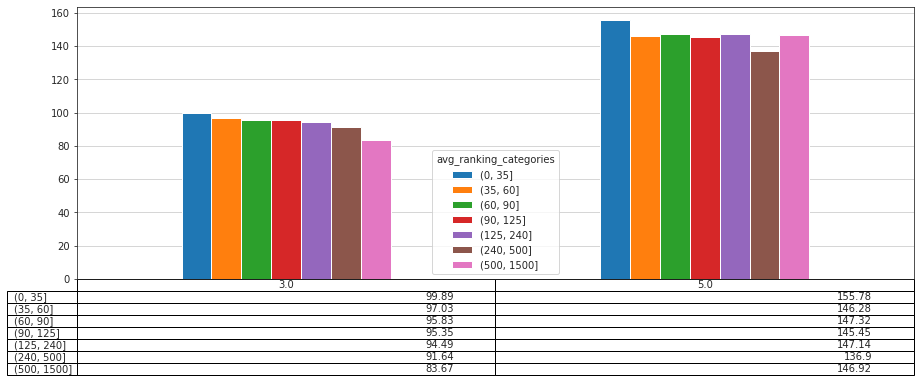

In [53]:
fig, ax = plt.subplots(1, 1)
ax.get_xaxis().set_visible(False)
data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack().plot(kind='bar', figsize=(15,5),
                                                                      table=np.round(data.groupby(['best_of', 'avg_ranking_categories'])['minutes'].mean().unstack().transpose(), 2)
                                                                      , grid=True, ax=ax)

### Analyse du top 1000 des matchs les plus rapides

In [76]:
top_1000_rapides_b03 = data[data['best_of']==3].nsmallest(1000, 'minutes')
top_1000_rapides_b05 = data[data['best_of']==5].nsmallest(1000, 'minutes')

###  Analyse du top 1000 des matchs les plus lents

In [77]:
top_1000_lents_b03 = data[data['best_of']==3].nlargest(1000, 'minutes')
top_1000_lents_b05 = data[data['best_of']==5].nlargest(1000, 'minutes')

Comparer les moyenne des ranks dans les différents matchs. On voit que dans les matchs les plus rapides le niveau est un peu moins bon que dans les matchs les plus lents. <br>
De manière général les longs matchs sont des matchs de haut niveai

In [78]:
diff_between_lent_rapide_b03 =[top_1000_lents_b03['minutes'].mean()-top_1000_rapides_b03['minutes'].mean(),
top_1000_lents_b03['winner_rank'].mean()-top_1000_rapides_b03['winner_rank'].mean(),
top_1000_lents_b03['loser_rank'].mean()-top_1000_rapides_b03['loser_rank'].mean(),
top_1000_lents_b03['diff_ranking'].mean()-top_1000_rapides_b03['diff_ranking'].mean(),
top_1000_lents_b03['avg_ranking'].mean()-top_1000_rapides_b03['avg_ranking'].mean()]

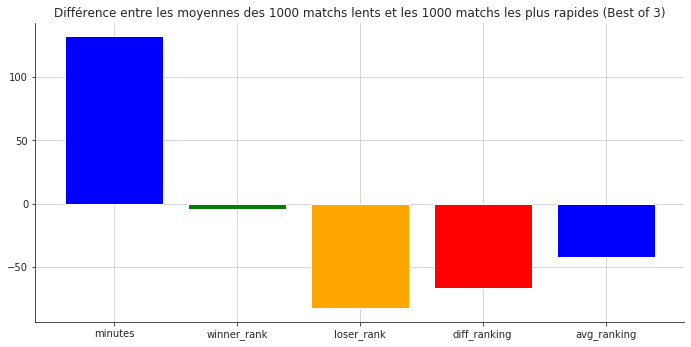

In [84]:
plt.figure(figsize=(10,5))
plt.grid()
plt.tight_layout(pad=2)
plt.bar(['minutes', 'winner_rank',  'loser_rank', 'diff_ranking', 'avg_ranking'],diff_between_lent_rapide_b03, color=['blue', 'green', 'orange', 'red'])
plt.title('Différence entre les moyennes des 1000 matchs lents et les 1000 matchs les plus rapides (Best of 3)')
sns.despine()
plt.show()

In [80]:
diff_between_lent_rapide_b05 =[top_1000_lents_b05['minutes'].mean()-top_1000_rapides_b05['minutes'].mean(),
top_1000_lents_b05['winner_rank'].mean()-top_1000_rapides_b05['winner_rank'].mean(),
top_1000_lents_b05['loser_rank'].mean()-top_1000_rapides_b05['loser_rank'].mean(),
top_1000_lents_b05['diff_ranking'].mean()-top_1000_rapides_b05['diff_ranking'].mean(),
top_1000_lents_b05['avg_ranking'].mean()-top_1000_rapides_b05['avg_ranking'].mean()]

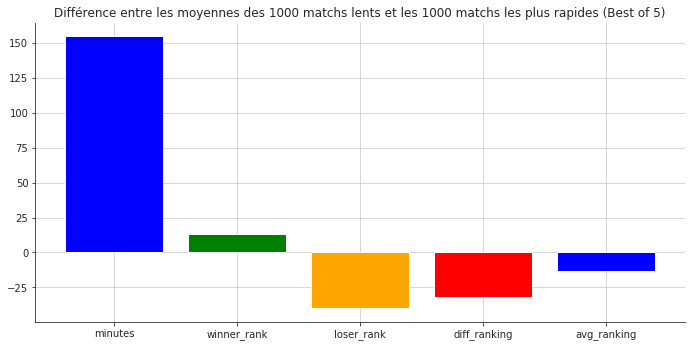

In [83]:
plt.figure(figsize=(10,5))
plt.grid()
plt.tight_layout(pad=2)
plt.bar(['minutes', 'winner_rank',  'loser_rank', 'diff_ranking', 'avg_ranking'],diff_between_lent_rapide_b05, color=['blue', 'green', 'orange', 'red'])
sns.despine()
plt.title('Différence entre les moyennes des 1000 matchs lents et les 1000 matchs les plus rapides (Best of 5)')
plt.show()

On constate via différence entre le top 1000 des matchs les plus lents et des matchs les plus rapides que les matchs qui dure plus longtemps (lents) on tendance à avoir un niveau plus homogène. <br>
La bar rouge de la colonne diff_ranking nous indique que plus un matchs est "lents" plus la différence de ranking est faible avec (-70 classements de différence en moins entre les deux joueurs pour les best of 3 et -35 pour les best of 5).<br>
La même analyse sur la colonne avg ranking nous indique que le niveau moyen est légérement meilleurs dans les matchs les plus longs.

In [86]:
data.groupby('surface')['minutes'].sort_values('tourney_date')

AttributeError: Cannot access callable attribute 'sort_values' of 'SeriesGroupBy' objects, try using the 'apply' method

In [87]:
df = pd.DataFrame()

In [88]:
df['int'] = [i for i in range(50)]

In [89]:
df

,int
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


In [96]:
df['roll']=df.rolling(3, win_type='triang').mean()

In [99]:
df = pd.Series(data=np.arange(10), 
               index=pd.date_range('2000', periods=10))

In [100]:
df.head()

2000-01-01    0
2000-01-02    1
2000-01-03    2
2000-01-04    3
2000-01-05    4
Freq: D, dtype: int64

In [103]:
df['roll']=df.rolling(2, closed='left').mean()

ValueError: closed only implemented for datetimelike and offset based windows

In [102]:
df

2000-01-01 00:00:00                                                    0
2000-01-02 00:00:00                                                    1
2000-01-03 00:00:00                                                    2
2000-01-04 00:00:00                                                    3
2000-01-05 00:00:00                                                    4
2000-01-06 00:00:00                                                    5
2000-01-07 00:00:00                                                    6
2000-01-08 00:00:00                                                    7
2000-01-09 00:00:00                                                    8
2000-01-10 00:00:00                                                    9
roll                   2000-01-01    NaN
2000-01-02    NaN
2000-01-03...
dtype: object

In [ ]:
def rolling_avg(seq, period):
    res = []
    for i in period:
        